# Importing Libraries and Dataset:

In [ ]:
!pip install catboost
!pip install gradio

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import gradio as gr
import lightgbm as lgb
from sklearn.preprocessing import OneHotEncoder
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Seoul Bike/SeoulBikeData.csv', encoding='latin-1')

In [ ]:
df.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


# Understanding the dataset:

In [ ]:
df.rename(columns = {'Date':'date', 'Rented Bike Count':'rented_bike_count', 'Hour':'hour', 'Temperature(°C)':'temperature', 'Humidity(%)':'humidity',
                     'Wind speed (m/s)':'wind_speed', 'Visibility (10m)':'visibility', 'Dew point temperature(°C)':'dew_point_temperature',
                     'Solar Radiation (MJ/m2)':'solar_radiation', 'Rainfall(mm)':'rainfall', 'Snowfall (cm)':'snowfall', 'Seasons':'seasons',
                     'Holiday':'holiday', 'Functioning Day':'functioning_day'}, inplace = True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   8760 non-null   object 
 1   rented_bike_count      8760 non-null   int64  
 2   hour                   8760 non-null   int64  
 3   temperature            8760 non-null   float64
 4   humidity               8760 non-null   int64  
 5   wind_speed             8760 non-null   float64
 6   visibility             8760 non-null   int64  
 7   dew_point_temperature  8760 non-null   float64
 8   solar_radiation        8760 non-null   float64
 9   rainfall               8760 non-null   float64
 10  snowfall               8760 non-null   float64
 11  seasons                8760 non-null   object 
 12  holiday                8760 non-null   object 
 13  functioning_day        8760 non-null   object 
dtypes: float64(6), int64(4), object(4)
memory usage: 958.2+ 

In [ ]:
#As the data variable is not in the correct data type, we will change it.
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')

#format='%d/%m/%Y': This argument is added to the pd.to_datetime function to specify the date format as Day/Month/Year.
#This tells pandas how to correctly interpret the date strings in your 'Date' column.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   8760 non-null   datetime64[ns]
 1   rented_bike_count      8760 non-null   int64         
 2   hour                   8760 non-null   int64         
 3   temperature            8760 non-null   float64       
 4   humidity               8760 non-null   int64         
 5   wind_speed             8760 non-null   float64       
 6   visibility             8760 non-null   int64         
 7   dew_point_temperature  8760 non-null   float64       
 8   solar_radiation        8760 non-null   float64       
 9   rainfall               8760 non-null   float64       
 10  snowfall               8760 non-null   float64       
 11  seasons                8760 non-null   object        
 12  holiday                8760 non-null   object        
 13  fun

In [ ]:
df.head()

,date,rented_bike_count,hour,temperature,humidity,wind_speed,visibility,dew_point_temperature,solar_radiation,rainfall,snowfall,seasons,holiday,functioning_day
0,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,2017-12-01,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,2017-12-01,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [ ]:
df.shape

(8760, 14)

In [ ]:
df.isnull().sum()

,0
date,0
rented_bike_count,0
hour,0
temperature,0
humidity,0
wind_speed,0
visibility,0
dew_point_temperature,0
solar_radiation,0
rainfall,0


#### There are no missing values in the data.

In [ ]:
df.describe()

,date,rented_bike_count,hour,temperature,humidity,wind_speed,visibility,dew_point_temperature,solar_radiation,rainfall,snowfall
count,8760,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,2018-05-31 23:59:59.999999744,704.602055,11.500000,12.882922,58.226256,1.724909,1436.825799,4.073813,0.569111,0.148687,0.075068
min,2017-12-01 00:00:00,0.000000,0.000000,-17.800000,0.000000,0.000000,27.000000,-30.600000,0.000000,0.000000,0.000000
25%,2018-03-02 00:00:00,191.000000,5.750000,3.500000,42.000000,0.900000,940.000000,-4.700000,0.000000,0.000000,0.000000
50%,2018-06-01 00:00:00,504.500000,11.500000,13.700000,57.000000,1.500000,1698.000000,5.100000,0.010000,0.000000,0.000000
75%,2018-08-31 00:00:00,1065.250000,17.250000,22.500000,74.000000,2.300000,2000.000000,14.800000,0.930000,0.000000,0.000000
max,2018-11-30 00:00:00,3556.000000,23.000000,39.400000,98.000000,7.400000,2000.000000,27.200000,3.520000,35.000000,8.800000
std,NaN,644.997468,6.922582,11.944825,20.362413,1.036300,608.298712,13.060369,0.868746,1.128193,0.436746


In [ ]:
df.nunique()

,0
date,365
rented_bike_count,2166
hour,24
temperature,546
humidity,90
wind_speed,65
visibility,1789
dew_point_temperature,556
solar_radiation,345
rainfall,61


In [ ]:
df.duplicated().sum()

0

#### There are no duplicate values in the data

# Exploratory Data Analysis:

## Checking for the distribution of the targeted value.

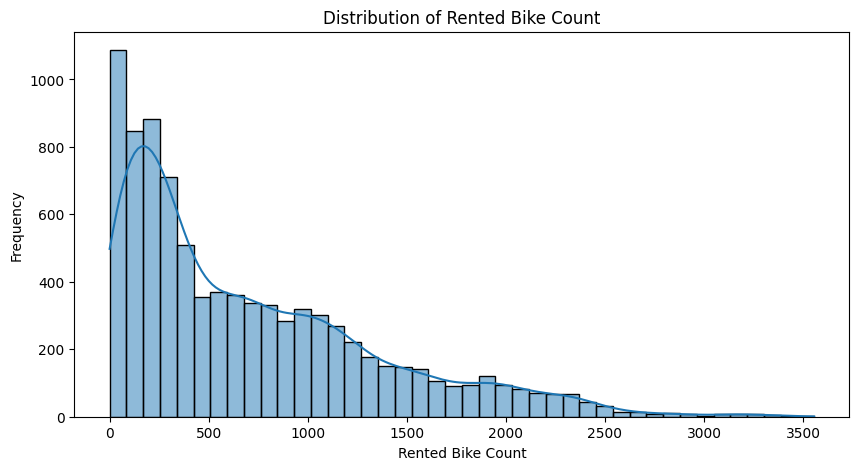

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(df['rented_bike_count'], kde=True)
plt.title('Distribution of Rented Bike Count')
plt.xlabel('Rented Bike Count')
plt.ylabel('Frequency')
plt.show();

### We can see that the rented bike count is right skewed.

## With the "hour" variable we are checking how bike rentals change across different times of the day.

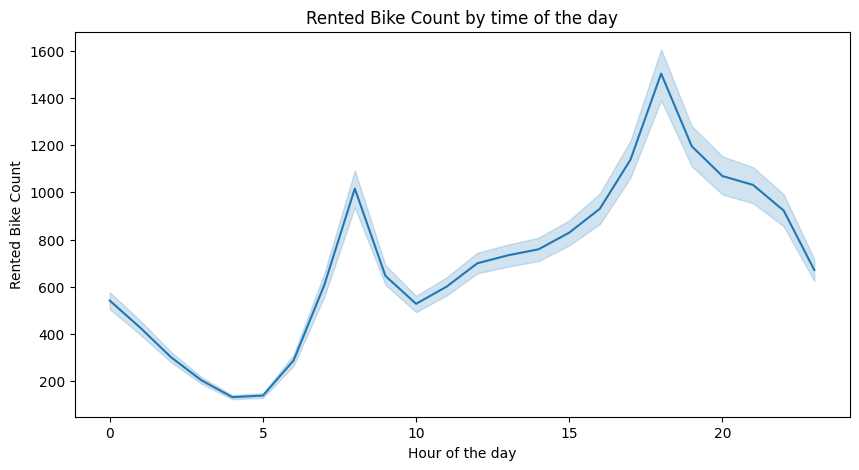

In [ ]:
plt.figure(figsize=(10, 5))
sns.lineplot(x='hour', y='rented_bike_count', data=df)
plt.title('Rented Bike Count by time of the day')
plt.xlabel('Hour of the day')
plt.ylabel('Rented Bike Count')
plt.show();

### We can see that the bikes are rented more during the evening and for a brief period in the morning, perhaps during the office commute hours.


## Checking the count of bikes rented season wise.

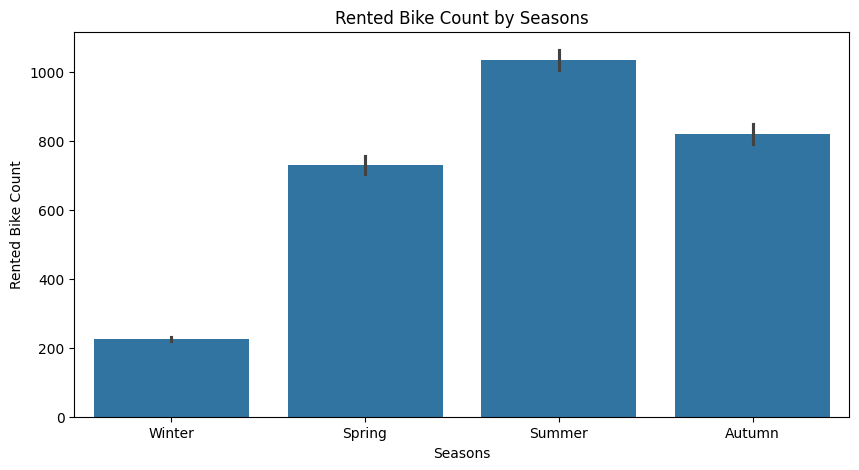

In [ ]:
plt.figure(figsize=(10, 5))
sns.barplot(x='seasons', y='rented_bike_count', data=df)
plt.title('Rented Bike Count by Seasons')
plt.xlabel('Seasons')
plt.ylabel('Rented Bike Count')
plt.show();

### We can see the bikes were rented more in Summer Season and very less in Winter Season.

## Checking for the count of bikes rented on holdiday and on non-holiday days.


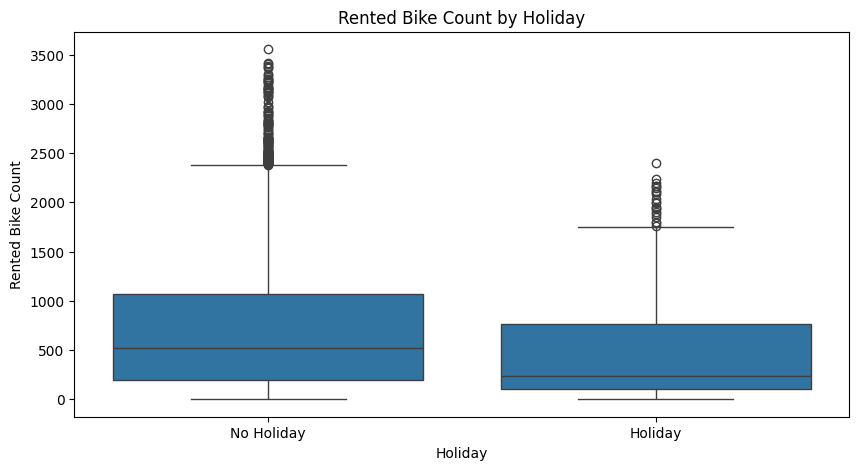

In [ ]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='holiday', y='rented_bike_count', data=df)
plt.title('Rented Bike Count by Holiday')
plt.xlabel('Holiday')
plt.ylabel('Rented Bike Count')
plt.show();

### We can observe that the bikes are rented more on 'No Holiday' days.

## Checking for the count of bikes rented on snowfall days.

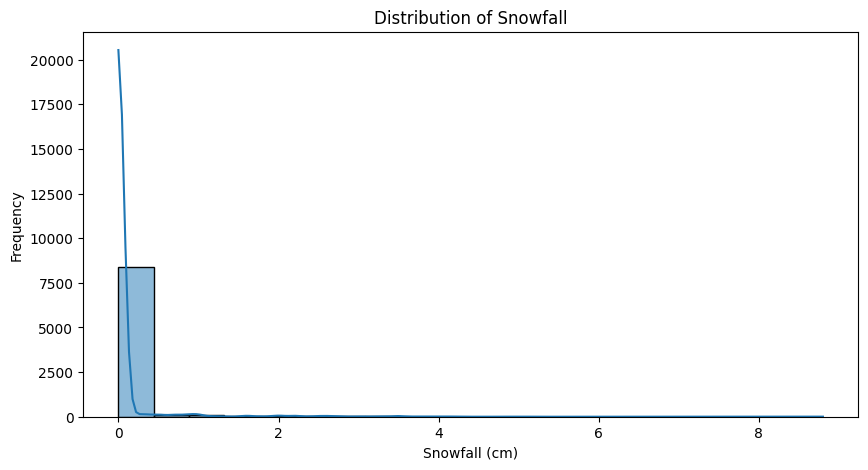

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(df['snowfall'], kde=True, bins=20)
plt.title('Distribution of Snowfall')
plt.xlabel('Snowfall (cm)')
plt.ylabel('Frequency')
plt.show();

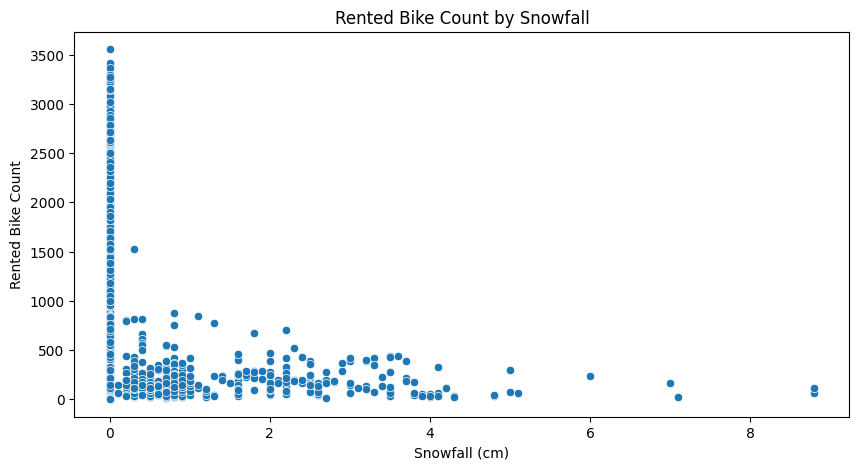

In [ ]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x='snowfall', y='rented_bike_count', data=df)
plt.title('Rented Bike Count by Snowfall')
plt.xlabel('Snowfall (cm)')
plt.ylabel('Rented Bike Count')
plt.show();

### Very less number of bikes are rented when there is snowfall.

## Checking distribution for Temperature variable and it's relation with our targeted variable.

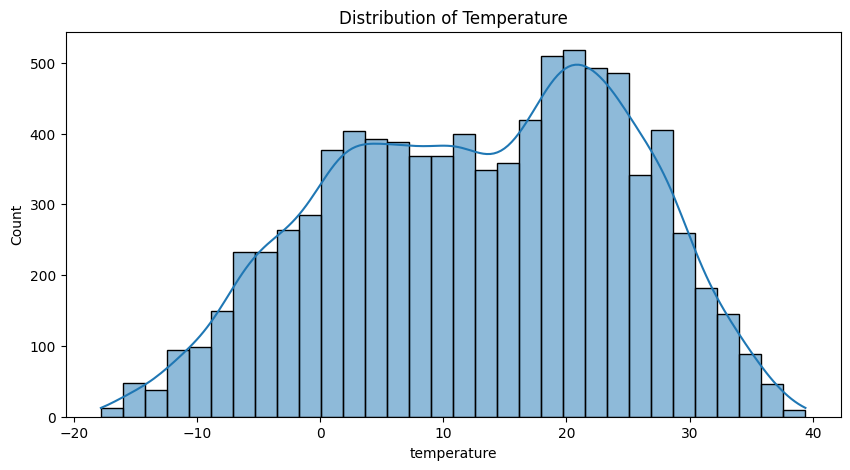

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(df['temperature'], kde=True)
plt.title('Distribution of Temperature')
plt.show();

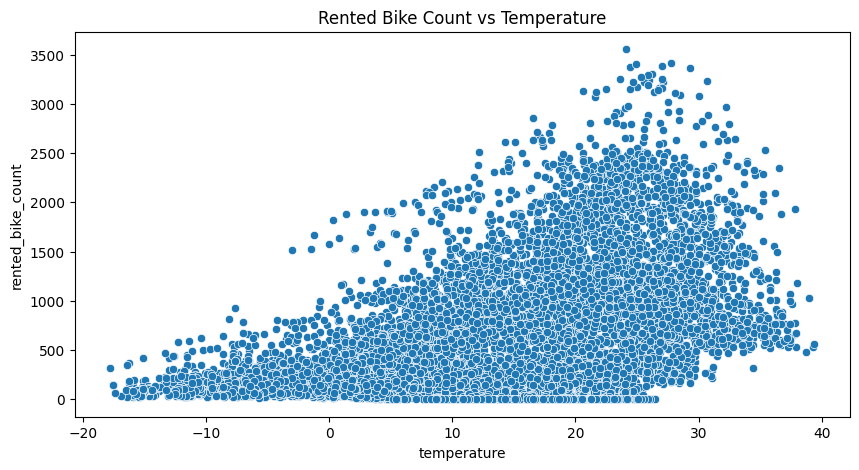

In [ ]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x='temperature', y='rented_bike_count', data=df)
plt.title('Rented Bike Count vs Temperature')
plt.show();

### We can see the bikes are rented much less at a very low temperature compared to the normal range of 20-35 (°C) and the temperature variable follows approximately Gausian distribution.



## Checking distribution for Solar Radiation variable and it's relation with our targeted variable.

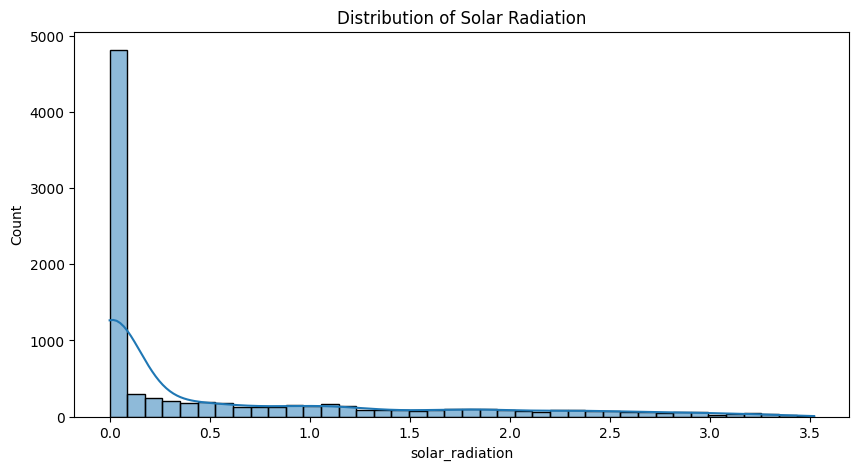

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(df['solar_radiation'], kde=True)
plt.title('Distribution of Solar Radiation')
plt.show();

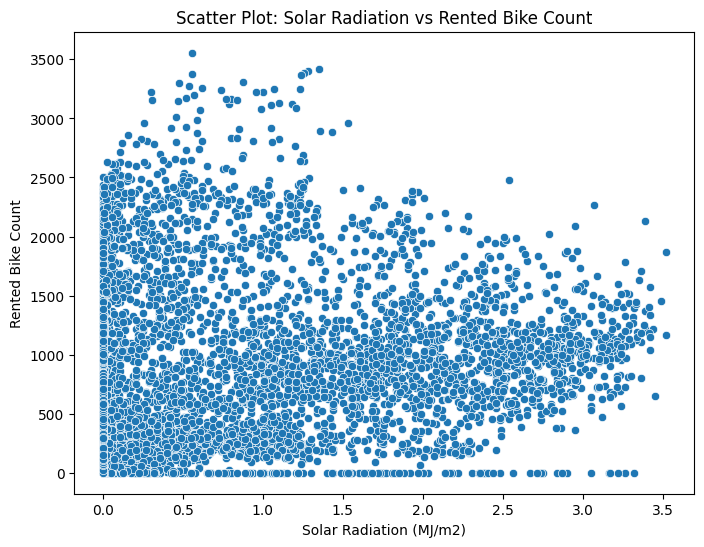

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='solar_radiation', y='rented_bike_count', data=df)
plt.title('Scatter Plot: Solar Radiation vs Rented Bike Count')
plt.xlabel('Solar Radiation (MJ/m2)')
plt.ylabel('Rented Bike Count')
plt.show();

### There is almost no correlation between solar radiation and rented bike count. This tells us that there is no linear relationship between them.



## Checking distribution of Humidity and it's relation with our targeted variable

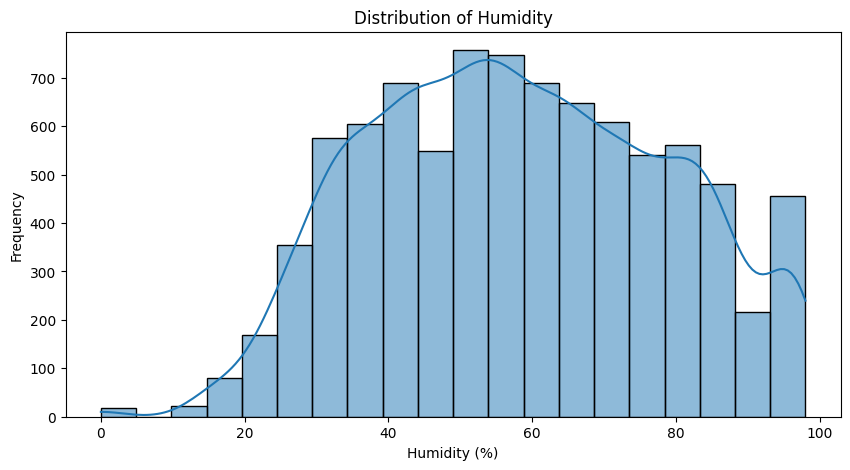

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(df['humidity'], kde=True, bins=20)
plt.title('Distribution of Humidity')
plt.xlabel('Humidity (%)')
plt.ylabel('Frequency')
plt.show();

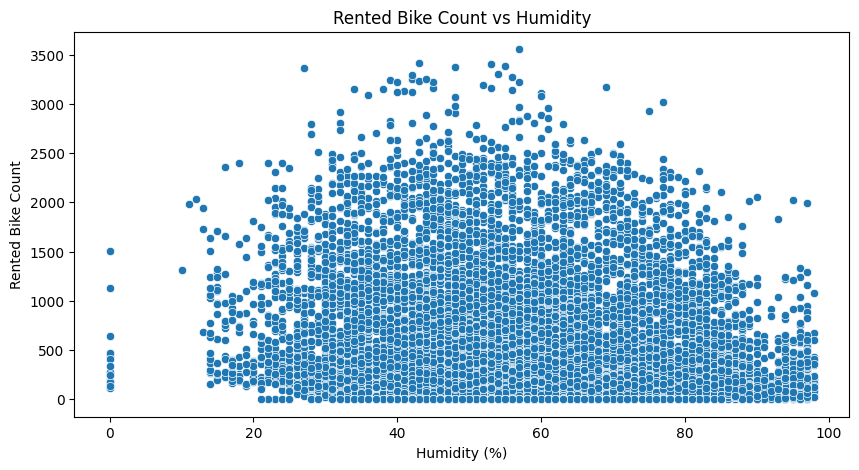

In [ ]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x='humidity', y='rented_bike_count', data=df)
plt.title('Rented Bike Count vs Humidity')
plt.xlabel('Humidity (%)')
plt.ylabel('Rented Bike Count')
plt.show();

### We can observe that the Humidity follows approx normal distribution and no correlation between humidity and bike rented count.

## Checking distribution of Visibility and it's relation with our targeted variable.

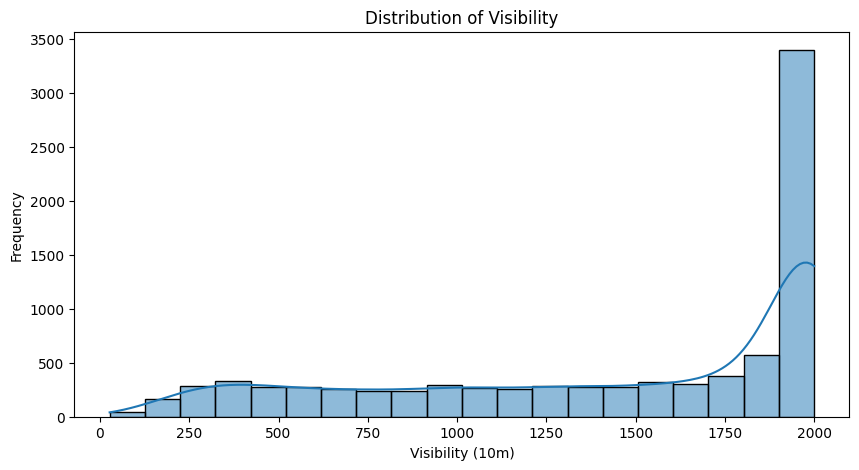

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(df['visibility'], kde=True, bins=20)
plt.title('Distribution of Visibility')
plt.xlabel('Visibility (10m)')
plt.ylabel('Frequency')
plt.show();

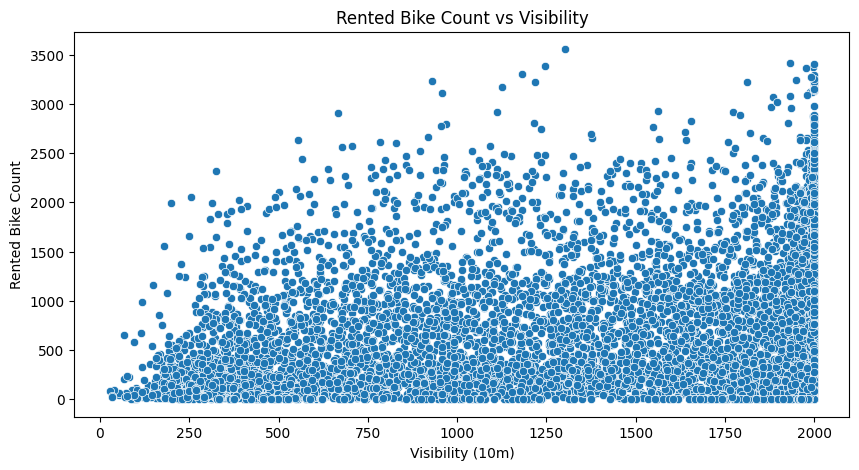

In [ ]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x='visibility', y='rented_bike_count', data=df)
plt.title('Rented Bike Count vs Visibility')
plt.xlabel('Visibility (10m)')
plt.ylabel('Rented Bike Count')
plt.show();

### The above graph shows the obvious results that the bikes are rented more when there is clear visibility and also the variable is left skewed. However, the correlation is very weak.

## Checking distribution of Wind Speed and it's distribution with our targeted variable.

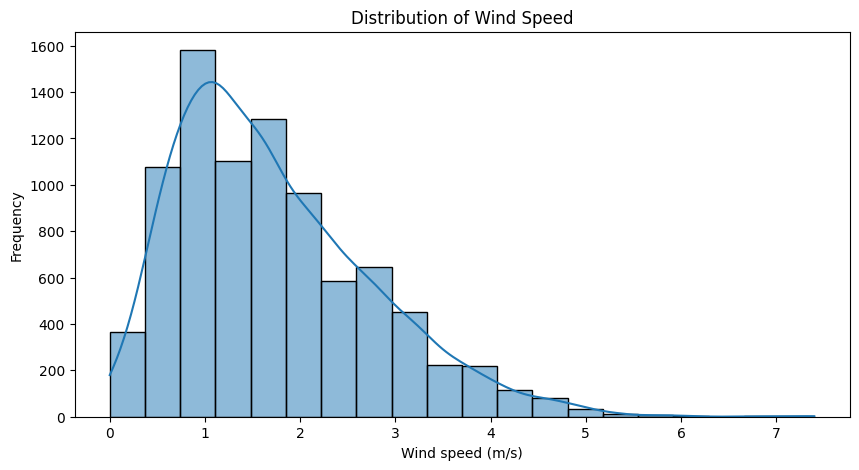

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(df['wind_speed'], kde=True, bins=20)
plt.title('Distribution of Wind Speed')
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Frequency')
plt.show();

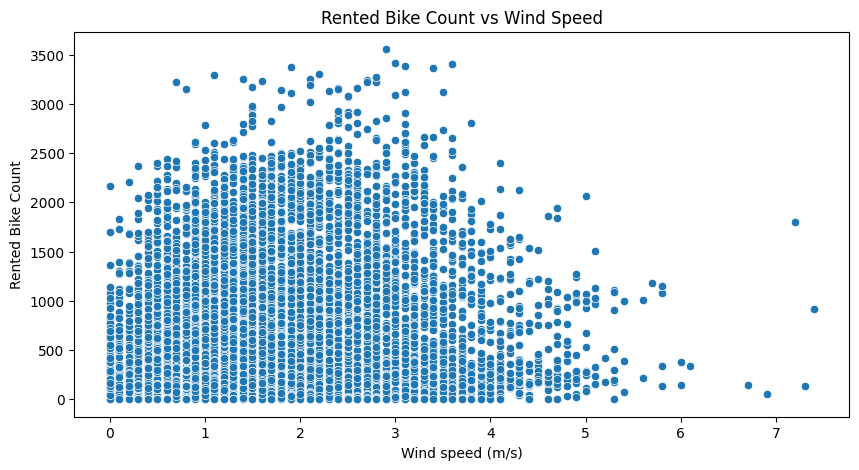

In [ ]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x='wind_speed', y='rented_bike_count', data=df)
plt.title('Rented Bike Count vs Wind Speed')
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Rented Bike Count')
plt.show();

### We can observe that Wind Speed is right skewed variable and the correlation is low.

## Checking distribution of Dew point temperature and its relation with our targetd variable.

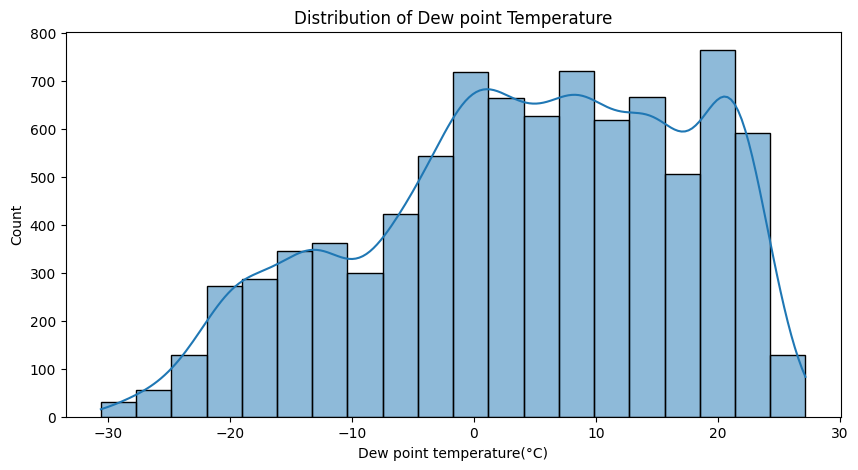

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(df['dew_point_temperature'], kde=True, bins=20)
plt.title('Distribution of Dew point Temperature')
plt.xlabel('Dew point temperature(°C)')
plt.show();

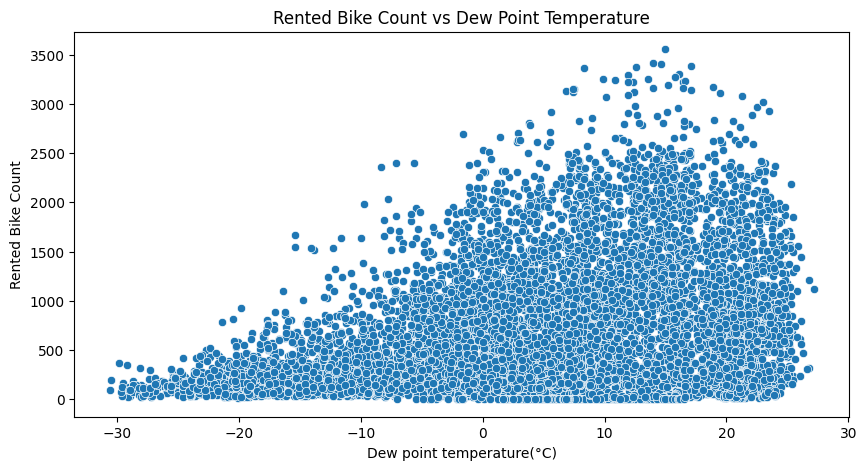

In [ ]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x='dew_point_temperature', y='rented_bike_count', data=df)
plt.title('Rented Bike Count vs Dew Point Temperature')
plt.xlabel('Dew point temperature(°C)')
plt.ylabel('Rented Bike Count')
plt.show();

### We can observe that the variable doesn't follow a normal distribution and the bike are rented more when the dew point temperature lies between 0 - 20 (°C).

# Data Preprocessing:

In [ ]:
df.head()

,date,rented_bike_count,hour,temperature,humidity,wind_speed,visibility,dew_point_temperature,solar_radiation,rainfall,snowfall,seasons,holiday,functioning_day
0,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,2017-12-01,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,2017-12-01,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


## Creating X and Y:

In [ ]:
X = df.drop('rented_bike_count', axis=1)
y = df['rented_bike_count']

## Fixing Outliers:

In [ ]:
def detect_outliers(dataframe, numerical_columns):
    outliers = []

    for column in numerical_columns:
        if column in dataframe.columns:
            q1 = dataframe[column].quantile(0.25)
            q3 = dataframe[column].quantile(0.75)
            iqr = q3 - q1
            fence_low = q1 - (1.5 * iqr)
            fence_high = q3 + (1.5 * iqr)
            num_outliers = dataframe.loc[(dataframe[column] < fence_low) | (dataframe[column] > fence_high)].shape[0]
            outliers.append({'Feature': column, 'Number of Outliers': num_outliers})

    outliers_df = pd.DataFrame(outliers, columns=['Feature', 'Number of Outliers'])
    return outliers_df

In [ ]:
numerical_columns = X.select_dtypes(include='number').columns.tolist()
X[numerical_columns].columns

Index(['hour', 'temperature', 'humidity', 'wind_speed', 'visibility',
       'dew_point_temperature', 'solar_radiation', 'rainfall', 'snowfall'],
      dtype='object')

In [ ]:
detect_outliers(X, numerical_columns)

,Feature,Number of Outliers
0,hour,0
1,temperature,0
2,humidity,0
3,wind_speed,161
4,visibility,0
5,dew_point_temperature,0
6,solar_radiation,641
7,rainfall,528
8,snowfall,443


In [ ]:
X['wind_speed'] = winsorize(X['wind_speed'], limits=(0.05, 0.05))
lower_limit_wind_speed = X['wind_speed'].quantile(0.05)
upper_limit_wind_speed = X['wind_speed'].quantile(0.95)

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


In [ ]:
X['solar_radiation'] = X['solar_radiation'].apply(lambda x: 0 if x == 0 else 1)
X['rainfall'] = X['rainfall'].apply(lambda x: 0 if x == 0 else 1)
X['snowfall'] = X['snowfall'].apply(lambda x: 0 if x == 0 else 1)

### We found outliers in wind_speed, solar_radiation, rainfall and snowfall.
### For fixing them we will apply winsorization on wind_speed and we will update the values of other variables as 0 and 1.
### Winsorization is the method used to reduce the impact of extreme values or outliers in a dataset by setting all the values above 95th percentile to the 95th percentile.
### And for rest we used apply function because we consider the value 0 as no rainfall, snowfall, and no solar radiation, and above 0 any values we consider as 1 to show that there is rainfall, snowfall, and solar radiation.


In [ ]:
# Extracting Year, Month and Day Of The Week from the date column.

X['year'] = X['date'].dt.year
X['month'] = X['date'].dt.month
X['day_of_week'] = X['date'].dt.dayofweek # Monday=0, Sunday=6

In [ ]:
X.head()

,date,hour,temperature,humidity,wind_speed,visibility,dew_point_temperature,solar_radiation,rainfall,snowfall,seasons,holiday,functioning_day,year,month,day_of_week
0,2017-12-01,0,-5.2,37,2.2,2000,-17.6,0,0,0,Winter,No Holiday,Yes,2017,12,4
1,2017-12-01,1,-5.5,38,0.8,2000,-17.6,0,0,0,Winter,No Holiday,Yes,2017,12,4
2,2017-12-01,2,-6.0,39,1.0,2000,-17.7,0,0,0,Winter,No Holiday,Yes,2017,12,4
3,2017-12-01,3,-6.2,40,0.9,2000,-17.6,0,0,0,Winter,No Holiday,Yes,2017,12,4
4,2017-12-01,4,-6.0,36,2.3,2000,-18.6,0,0,0,Winter,No Holiday,Yes,2017,12,4


In [ ]:
#Dropping date column
X = X.drop('date', axis=1)

## Encoding categorical variables:

In [ ]:
#Manually encoding holiday and functioning day variables.
X['holiday'] = X['holiday'].map({'No Holiday':0, 'Holiday':1})
X['functioning_day'] = X['functioning_day'].map({'No':0, 'Yes':1})

#Applying one hot encoder on others.
encoder = OneHotEncoder(drop='first', sparse_output = False)
encoded_columns = encoder.fit_transform(X[['hour', 'seasons', 'year', 'month', 'day_of_week']])
encoded_column_names = encoder.get_feature_names_out(['hour', 'seasons', 'year', 'month', 'day_of_week'])
encoded_df = pd.DataFrame(encoded_columns, columns=encoded_column_names)
X = pd.concat([X.drop(['seasons', 'year', 'month', 'day_of_week'], axis=1), encoded_df], axis=1)

## Data Transformation:

### In regression, the assumption is that the targeted variable should follow a normal distribution. Since our variable is right-skewed, we will take the square root of the 'y' variable to make it follow a normal distribution.

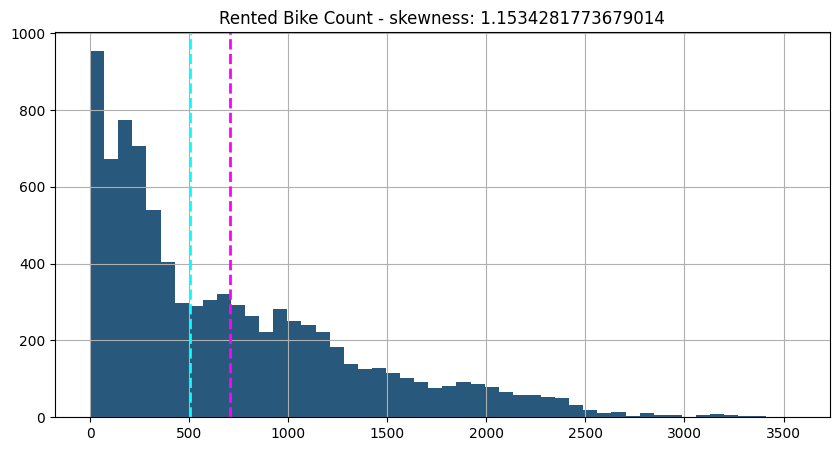

In [ ]:
plt.figure(figsize=(10,5))
feature = y
feature.hist(bins=50, color = '#28587B')
plt.axvline(feature.mean(), color='magenta', linestyle='dashed', linewidth=2)
plt.axvline(feature.median(), color='cyan', linestyle='dashed', linewidth=2)
plt.title('Rented Bike Count - skewness: ' + str(y.skew()))
plt.show();

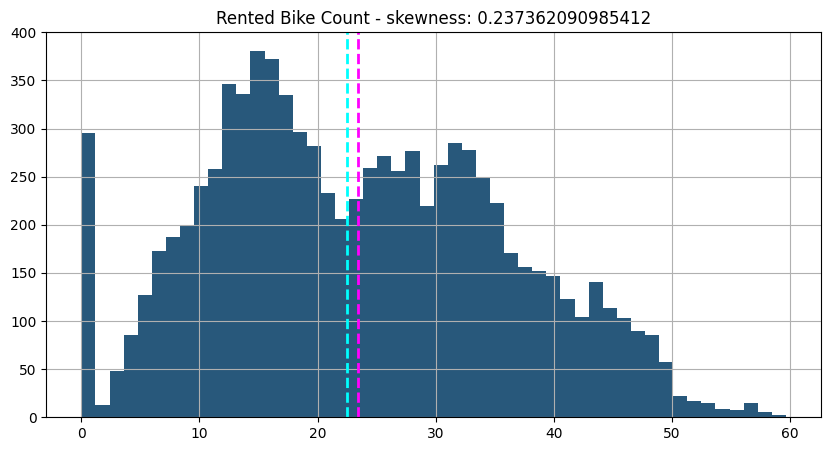

In [ ]:
y = y**0.5
plt.figure(figsize=(10,5))
feature = y
feature.hist(bins=50, color = '#28587B')
plt.axvline(feature.mean(), color='magenta', linestyle='dashed', linewidth=2)
plt.axvline(feature.median(), color='cyan', linestyle='dashed', linewidth=2)
plt.title('Rented Bike Count - skewness: ' + str(y.skew()))
plt.show();

## Feature Selection:

In [ ]:
# Multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [ ]:
numerical_col = ['temperature', 'humidity', 'wind_speed', 'visibility', 'dew_point_temperature', 'solar_radiation', 'snowfall']

In [ ]:
# VIF values
calc_vif(df[[i for i in numerical_col if i not in ['date','rented_bike_count']]])

,variables,VIF
0,temperature,29.055352
1,humidity,4.916849
2,wind_speed,4.508141
3,visibility,8.982885
4,dew_point_temperature,15.182034
5,solar_radiation,2.821594
6,snowfall,1.118499


In [ ]:
# VIF values
calc_vif(df[[i for i in numerical_col if i not in ['date','rented_bike_count', 'dew_point_temperature']]])

,variables,VIF
0,temperature,3.164308
1,humidity,4.589323
2,wind_speed,4.074500
3,visibility,4.293131
4,solar_radiation,2.245304
5,snowfall,1.118499


In [ ]:
X.drop(columns = 'dew_point_temperature', inplace = True)

## Data Scaling:

In [ ]:
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

## Data Splitting:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(6132, 54)
(2628, 54)
(6132,)
(2628,)


# Data Modelling:

## Linear Regression:

In [ ]:
model = LinearRegression()

param_grid = {'fit_intercept': [True, False]}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='r2', cv=5, n_jobs=-1)

start_time = time.time()

grid_search.fit(X_train, y_train)

end_time = time.time()

lin_best_model = grid_search.best_estimator_

y_pred = lin_best_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
n = X_test.shape[0]
p = X_test.shape[1]
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
time_taken = end_time - start_time

lin_results = pd.DataFrame({
    'model_name': ['Linear Regression'],
    'rmse': [rmse],
    'r2_score': [r2],
    'adjusted_r2': [adjusted_r2],
    'time_taken': [time_taken]
})

print("Best Model Coefficients:")
print(lin_best_model.coef_)

print("\nModel Performance:")
lin_results

Best Model Coefficients:
[-1.10067491e+12  5.52014160e+00 -1.88574219e+00  3.30810547e-02
  4.01611328e-01  1.89538574e+00 -3.13635254e+00  1.38977051e-01
 -6.87744141e-01  5.17211914e+00  3.17737479e+10  6.35474958e+10
  9.53212438e+10  1.27094992e+11  1.58868740e+11  1.90642488e+11
  2.22416235e+11  2.54189983e+11  2.85963731e+11  3.17737479e+11
  3.49511227e+11  3.81284975e+11  4.13058723e+11  4.44832471e+11
  4.76606219e+11  5.08379967e+11  5.40153715e+11  5.71927463e+11
  6.03701211e+11  6.35474958e+11  6.67248706e+11  6.99022454e+11
  7.30796202e+11  1.23247151e+12  1.91180570e+12 -1.23234780e+12
  2.20888538e+10 -1.06921788e-01 -1.58840262e+12 -1.56491065e+12
 -1.58840262e+12 -1.99463628e+12 -2.02457917e+12 -2.02457917e+12
 -7.85287573e+11 -7.97076076e+11 -7.85287573e+11  2.20888538e+10
  1.81773226e-01  2.61394136e-01  1.24528507e-01  4.51208022e-01
  3.16215861e-03 -5.49295952e-01]

Model Performance:


,model_name,rmse,r2_score,adjusted_r2,time_taken
0,Linear Regression,5.439462,0.807369,0.803326,6.230439


## Lasso Model:

In [ ]:
model = Lasso()

param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100],
    'fit_intercept': [True, False],
    'max_iter': [1000, 2000, 3000]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='r2', cv=5, n_jobs=-1)

start_time = time.time()

grid_search.fit(X_train, y_train)

end_time = time.time()

lasso_best_model = grid_search.best_estimator_

y_pred = lasso_best_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
n = X_test.shape[0]
p = X_test.shape[1]
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
time_taken = end_time - start_time

lasso_results = pd.DataFrame({
    'model_name': ['Lasso Regression'],
    'rmse': [rmse],
    'r2_score': [r2],
    'adjusted_r2': [adjusted_r2],
    'time_taken': [time_taken]
})

print("Best Model Coefficients:")
print(lasso_best_model.coef_)

print("\nModel Performance:")
lasso_results

Best Model Coefficients:
[ 0.04036139  5.51043316 -1.88383666  0.03101118  0.4017212   1.87877742
 -3.13764053  0.13609295 -0.68422996  5.17035837 -0.53543869 -1.07054875
 -1.38610828 -2.00181094 -1.88884413 -0.98229504 -0.0615935   0.85560081
 -0.35902357 -1.20353874 -1.16903773 -0.91644125 -0.94808527 -0.96869346
 -0.75462479 -0.41052267  0.23449097  1.54552365  1.00821086  0.90927671
  1.22351549  0.91545153  0.18682577 -0.         -0.         -2.26418099
 -0.39338364 -0.10693492 -0.58216314 -0.          0.6675055   1.05245505
 -0.474019   -1.09761487  0.47879777  1.14500923  0.70972391  0.22714618
  0.1765873   0.25653893  0.12041764  0.44626982  0.         -0.55145718]

Model Performance:


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.624e+02, tolerance: 9.538e+01
  model = cd_fast.enet_coordinate_descent(


,model_name,rmse,r2_score,adjusted_r2,time_taken
0,Lasso Regression,5.439037,0.807399,0.803357,38.833574


## Ridge Model:

In [ ]:
model = Ridge()

param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100],
    'fit_intercept': [True, False],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg']
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='r2', cv=5, n_jobs=-1)

start_time = time.time()

grid_search.fit(X_train, y_train)

end_time = time.time()

ridge_best_model = grid_search.best_estimator_

y_pred = ridge_best_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
n = X_test.shape[0]
p = X_test.shape[1]
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
time_taken = end_time - start_time

ridge_results = pd.DataFrame({
    'model_name': ['Ridge Regression'],
    'rmse': [rmse],
    'r2_score': [r2],
    'adjusted_r2': [adjusted_r2],
    'time_taken': [time_taken]
})

print("Best Model Coefficients:")
print(ridge_best_model.coef_)

print("\nModel Performance:")
ridge_results

Best Model Coefficients:
[ 1.33618726e-01  5.44606379e+00 -1.88349925e+00  3.07396609e-02
  3.96287042e-01  1.86541438e+00 -3.13650410e+00  1.31344503e-01
 -6.83944738e-01  5.16052694e+00 -5.31238271e-01 -1.06893435e+00
 -1.38712811e+00 -2.00470189e+00 -1.89492666e+00 -9.91553944e-01
 -7.31116230e-02  8.44354029e-01 -3.71083210e-01 -1.21512229e+00
 -1.18177480e+00 -9.30896524e-01 -9.64418719e-01 -9.87148906e-01
 -7.76049589e-01 -4.35208299e-01  2.07707137e-01  1.51244370e+00
  9.70563944e-01  8.66154325e-01  1.17507422e+00  8.64141049e-01
  1.33707821e-01  1.75177263e-01  1.47143096e-02 -2.02396384e+00
 -3.09718815e-01 -1.08262099e-01 -5.26491177e-01  6.17993541e-02
  7.38440069e-01  1.23126155e+00 -2.84543968e-01 -9.05590444e-01
  6.64089088e-01  1.31889757e+00  8.73219474e-01  3.09718815e-01
  1.79129223e-01  2.60103221e-01  1.22732633e-01  4.47679392e-01
  3.63847567e-03 -5.48923287e-01]

Model Performance:


,model_name,rmse,r2_score,adjusted_r2,time_taken
0,Ridge Regression,5.439681,0.807354,0.80331,3.481064


## ElasticNet Model:

In [ ]:
model = ElasticNet()

param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100],
    'l1_ratio': [0.1, 0.5, 0.9, 1],
    'fit_intercept': [True, False],
    'max_iter': [1000, 2000, 3000]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='r2', cv=5, n_jobs=-1)

start_time = time.time()

grid_search.fit(X_train, y_train)

end_time = time.time()

elastic_net_best_model = grid_search.best_estimator_

y_pred = elastic_net_best_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
n = X_test.shape[0]
p = X_test.shape[1]
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
time_taken = end_time - start_time

elastic_net_results = pd.DataFrame({
    'model_name': ['Elastic Net Regression'],
    'rmse': [rmse],
    'r2_score': [r2],
    'adjusted_r2': [adjusted_r2],
    'time_taken': [time_taken]
})

print("Best Model Coefficients:")
print(elastic_net_best_model.coef_)

print("\nModel Performance:")
elastic_net_results

Best Model Coefficients:
[ 4.51993234e-01  5.47646527e+00 -1.88475429e+00  3.13675605e-02
  3.98261399e-01  1.87848308e+00 -3.13694142e+00  1.34267944e-01
 -6.84422090e-01  5.16570406e+00 -5.46808623e-01 -1.09368636e+00
 -1.42110209e+00 -2.04824578e+00 -1.94741120e+00 -1.05357872e+00
 -1.45386736e-01  7.61299646e-01 -4.65333614e-01 -1.32012877e+00
 -1.29671949e+00 -1.05550201e+00 -1.09864787e+00 -1.13082145e+00
 -9.28761764e-01 -5.96831293e-01  3.73453630e-02  1.33498908e+00
  7.85706471e-01  6.74224652e-01  9.75967599e-01  6.56049694e-01
 -8.37108410e-02  2.01102351e-01 -2.21001106e-02 -2.12939056e+00
 -2.63035952e-01 -1.07750419e-01 -6.17371777e-01 -3.08276223e-02
  6.40885840e-01  1.17120666e+00 -3.49722018e-01 -9.71753756e-01
  5.82698964e-01  1.24319877e+00  8.02217473e-01  3.57981470e-01
  1.79244886e-01  2.59608365e-01  1.22859457e-01  4.48268072e-01
  2.97740606e-03 -5.49577785e-01]

Model Performance:


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.217e+04, tolerance: 9.538e+01
  model = cd_fast.enet_coordinate_descent(


,model_name,rmse,r2_score,adjusted_r2,time_taken
0,Elastic Net Regression,5.439377,0.807375,0.803332,93.293981


## Decision Tree:

In [ ]:
model = DecisionTreeRegressor()

param_grid = {
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='r2', cv=5, n_jobs=-1)

start_time = time.time()

grid_search.fit(X_train, y_train)

end_time = time.time()

dt_best_model = grid_search.best_estimator_

y_pred = dt_best_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
n = X_test.shape[0]
p = X_test.shape[1]
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
time_taken = end_time - start_time

dt_results = pd.DataFrame({
    'model_name': ['Decision Tree'],
    'rmse': [rmse],
    'r2_score': [r2],
    'adjusted_r2': [adjusted_r2],
    'time_taken': [time_taken]
})

print("Best Model Feature Importances:")
print(dt_best_model.feature_importances_)

print("\nModel Performance:")
dt_results

Best Model Feature Importances:
[1.94050345e-01 2.49186620e-01 2.87928983e-02 1.10472224e-03
 1.51000669e-03 3.04772763e-02 1.20192366e-01 1.55491412e-03
 5.01285731e-03 1.57265126e-01 2.35763269e-04 1.85305144e-03
 1.45934327e-03 0.00000000e+00 4.26775210e-05 8.10729873e-03
 1.02745648e-02 9.93337812e-03 7.05475107e-04 1.01207761e-03
 1.89786993e-04 8.35056973e-05 0.00000000e+00 1.98302288e-05
 4.60793596e-03 2.81311172e-03 1.08341205e-03 1.81014278e-02
 1.82809628e-03 1.91274361e-04 2.35606101e-05 6.31699638e-04
 4.76125292e-03 6.42897146e-04 3.93680117e-04 6.78567884e-02
 5.65026372e-04 9.22469548e-05 1.66034865e-02 2.83443590e-03
 7.86157778e-04 1.73312942e-03 3.72494009e-03 4.20319864e-03
 3.88750684e-04 5.10568941e-04 3.03471808e-03 4.23096096e-04
 9.11976162e-04 1.65841770e-03 5.02438594e-03 1.17287033e-03
 1.47452387e-02 1.55883337e-02]

Model Performance:


,model_name,rmse,r2_score,adjusted_r2,time_taken
0,Decision Tree,3.994426,0.896122,0.893942,646.264345


## Random Forest:

In [ ]:
model = RandomForestRegressor()

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='r2', cv=5, n_jobs=-1)

start_time = time.time()

grid_search.fit(X_train, y_train)

end_time = time.time()

rf_best_model = grid_search.best_estimator_

y_pred = rf_best_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
n = X_test.shape[0]
p = X_test.shape[1]
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
time_taken = end_time - start_time

rf_results = pd.DataFrame({
    'model_name': ['Random Forest'],
    'rmse': [rmse],
    'r2_score': [r2],
    'adjusted_r2': [adjusted_r2],
    'time_taken': [time_taken]
})

print("Best Model Feature Importances:")
print(rf_best_model.feature_importances_)

print("\nModel Performance:")
rf_results

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
540 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
135 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py"

Best Model Feature Importances:
[0.14670508 0.15458189 0.08477257 0.02788081 0.03811298 0.04547374
 0.04554337 0.00586888 0.0045052  0.12054853 0.00175757 0.00297513
 0.00702126 0.01412315 0.01221899 0.00301923 0.00262877 0.00747164
 0.00113395 0.0032018  0.00173406 0.00089579 0.00091058 0.00087311
 0.00107073 0.00177147 0.00344222 0.0153935  0.00660963 0.00414021
 0.00705704 0.00421992 0.00280998 0.00612488 0.02424237 0.08302174
 0.00600716 0.01055736 0.00764056 0.00297165 0.00553499 0.01308279
 0.00345862 0.00355203 0.00478758 0.00583972 0.00591824 0.00550176
 0.00496067 0.00363299 0.00450546 0.00352444 0.0062988  0.00836337]

Model Performance:


,model_name,rmse,r2_score,adjusted_r2,time_taken
0,Random Forest,3.716371,0.910081,0.908194,648.868995


## Gradient Boosting Regressor:

In [ ]:
model = GradientBoostingRegressor()

param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='r2', cv=5, n_jobs=-1)

start_time = time.time()

grid_search.fit(X_train, y_train)

end_time = time.time()

gb_best_model = grid_search.best_estimator_

y_pred = gb_best_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
n = X_test.shape[0]
p = X_test.shape[1]
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
time_taken = end_time - start_time

gb_results = pd.DataFrame({
    'model_name': ['Gradient Boosting'],
    'rmse': [rmse],
    'r2_score': [r2],
    'adjusted_r2': [adjusted_r2],
    'time_taken': [time_taken]
})

print("Best Model Feature Importances:")
print(gb_best_model.feature_importances_)

print("\nModel Performance:")
gb_results

Best Model Feature Importances:
[2.20028242e-01 2.77232530e-01 1.32063510e-01 3.95511129e-03
 6.61570258e-03 7.37852852e-03 5.14910995e-02 8.52911209e-04
 3.07271728e-03 1.60868846e-01 4.74546866e-05 7.61379423e-05
 2.79246305e-04 2.76116866e-03 1.50054061e-03 4.58858860e-04
 3.14812785e-03 1.26476794e-02 3.11033887e-04 1.66533394e-03
 4.67090421e-04 8.96849299e-05 2.33515017e-04 1.52954150e-04
 5.67765729e-04 3.95653742e-04 3.86869203e-04 1.00370222e-02
 1.09578852e-03 2.05846141e-04 1.43140994e-04 6.14521176e-05
 2.78817456e-03 1.14244668e-03 3.28340124e-04 3.99960761e-02
 2.86591675e-04 1.92424583e-04 2.64395370e-03 1.42161235e-03
 2.58814745e-03 4.24457139e-03 3.81673646e-04 3.24125826e-03
 5.45341323e-04 6.35310551e-03 4.50627808e-03 8.27869372e-04
 6.38522625e-04 7.03816188e-04 5.77562037e-04 9.71044799e-04
 1.20757368e-02 1.32538890e-02]

Model Performance:


,model_name,rmse,r2_score,adjusted_r2,time_taken
0,Gradient Boosting,3.100927,0.937397,0.936083,321.963729


## Ada Boost Regressor:

In [ ]:
base_estimator = DecisionTreeRegressor(max_depth=3)

model = AdaBoostRegressor(estimator=base_estimator)

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0],
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='r2', cv=5, n_jobs=-1)

start_time = time.time()

grid_search.fit(X_train, y_train)

end_time = time.time()

adaboost_best_model = grid_search.best_estimator_

y_pred = adaboost_best_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
n = X_test.shape[0]
p = X_test.shape[1]
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
time_taken = end_time - start_time

adaboost_results = pd.DataFrame({
    'model_name': ['AdaBoost Regression'],
    'rmse': [rmse],
    'r2_score': [r2],
    'adjusted_r2': [adjusted_r2],
    'time_taken': [time_taken]
})

print("Best Model Parameters:")
print(adaboost_best_model.get_params())

print("\nModel Performance:")
adaboost_results

Best Model Parameters:
{'estimator__ccp_alpha': 0.0, 'estimator__criterion': 'squared_error', 'estimator__max_depth': 3, 'estimator__max_features': None, 'estimator__max_leaf_nodes': None, 'estimator__min_impurity_decrease': 0.0, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__min_weight_fraction_leaf': 0.0, 'estimator__monotonic_cst': None, 'estimator__random_state': None, 'estimator__splitter': 'best', 'estimator': DecisionTreeRegressor(max_depth=3), 'learning_rate': 0.1, 'loss': 'linear', 'n_estimators': 200, 'random_state': None}

Model Performance:


,model_name,rmse,r2_score,adjusted_r2,time_taken
0,AdaBoost Regression,6.75688,0.70276,0.696522,63.042929


## Cat Boost Regressor:

In [ ]:
model = CatBoostRegressor(silent=True)

param_grid = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.3],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5],
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='r2', cv=5, n_jobs=-1)

start_time = time.time()

grid_search.fit(X_train, y_train)

end_time = time.time()

catboost_best_model = grid_search.best_estimator_

y_pred = catboost_best_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
n = X_test.shape[0]
p = X_test.shape[1]
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
time_taken = end_time - start_time

catboost_results = pd.DataFrame({
    'model_name': ['CatBoost Regression'],
    'rmse': [rmse],
    'r2_score': [r2],
    'adjusted_r2': [adjusted_r2],
    'time_taken': [time_taken]
})

print("Best Model Parameters:")
print(catboost_best_model.get_params())

print("\nModel Performance:")
catboost_results

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Model Parameters:
{'loss_function': 'RMSE', 'silent': True, 'depth': 8, 'iterations': 300, 'l2_leaf_reg': 5, 'learning_rate': 0.3}

Model Performance:


,model_name,rmse,r2_score,adjusted_r2,time_taken
0,CatBoost Regression,2.785341,0.949491,0.948431,372.345991


## Light GBM Regressor:

In [ ]:
model = lgb.LGBMRegressor()

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [-1, 3, 5, 7],
    'num_leaves': [31, 50, 100]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='r2', cv=5, n_jobs=-1)

start_time = time.time()

grid_search.fit(X_train, y_train)

end_time = time.time()

lightgbm_best_model = grid_search.best_estimator_

y_pred = lightgbm_best_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
n = X_test.shape[0]
p = X_test.shape[1]
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
time_taken = end_time - start_time

lightgbm_results = pd.DataFrame({
    'model_name': ['LightGBM Regression'],
    'rmse': [rmse],
    'r2_score': [r2],
    'adjusted_r2': [adjusted_r2],
    'time_taken': [time_taken]
})

print("Best Model Parameters:")
print(lightgbm_best_model.get_params())

print("\nModel Performance:")
lightgbm_results

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002926 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 790
[LightGBM] [Info] Number of data points in the train set: 6132, number of used features: 54
[LightGBM] [Info] Start training from score 23.579345
Best Model Parameters:
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 300, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}

Model Performance:


,model_name,rmse,r2_score,adjusted_r2,time_taken
0,LightGBM Regression,2.854969,0.946934,0.94582,156.227989


## Best Model Evaluation:

In [ ]:
results = pd.concat([lin_results, lasso_results, ridge_results, elastic_net_results, dt_results, rf_results, gb_results, adaboost_results, catboost_results, lightgbm_results])
results

,model_name,rmse,r2_score,adjusted_r2,time_taken
0,Linear Regression,5.439462,0.807369,0.803326,6.230439
0,Lasso Regression,5.439037,0.807399,0.803357,38.833574
0,Ridge Regression,5.439681,0.807354,0.803310,3.481064
0,Elastic Net Regression,5.439377,0.807375,0.803332,93.293981
0,Decision Tree,3.994426,0.896122,0.893942,646.264345
0,Random Forest,3.716371,0.910081,0.908194,648.868995
0,Gradient Boosting,3.100927,0.937397,0.936083,321.963729
0,AdaBoost Regression,6.756880,0.702760,0.696522,63.042929
0,CatBoost Regression,2.785341,0.949491,0.948431,372.345991
0,LightGBM Regression,2.854969,0.946934,0.945820,156.227989


# Deployment:

In [ ]:
def wind_speed_outliers(a, lower_limit_wind_speed = lower_limit_wind_speed, upper_limit_wind_speed = upper_limit_wind_speed):
  if a < lower_limit_wind_speed:
    return lower_limit_wind_speed
  elif a > upper_limit_wind_speed:
    return upper_limit_wind_speed
  else:
    return a

In [ ]:
def preprocess_input(new_df):

  new_df['date'] = pd.to_datetime(new_df['date'])

  new_df['wind_speed'] = new_df['wind_speed'].apply(wind_speed_outliers)

  new_df['solar_radiation'] = new_df['solar_radiation'].apply(lambda x: 0 if x == 0 else 1)
  new_df['rainfall'] = new_df['rainfall'].apply(lambda x: 0 if x == 0 else 1)
  new_df['snowfall'] = new_df['snowfall'].apply(lambda x: 0 if x == 0 else 1)

  new_df['year'] = new_df['date'].dt.year
  new_df['month'] = new_df['date'].dt.month
  new_df['day_of_week'] = new_df['date'].dt.dayofweek
  new_df = new_df.drop(['date', 'dew_point_temperature'], axis=1)

  new_df['holiday'] = new_df['holiday'].map({'No Holiday':0, 'Holiday':1})
  new_df['functioning_day'] = new_df['functioning_day'].map({'No':0, 'Yes':1})

  encoded_cols = encoder.transform(new_df[['hour', 'seasons', 'year', 'month', 'day_of_week']])
  new_encoded_df = pd.DataFrame(encoded_cols, columns=encoded_column_names)
  new_df = pd.concat([new_df.drop(['seasons', 'year', 'month', 'day_of_week'], axis=1), new_encoded_df], axis=1)

  new_df = scaler.transform(new_df)

  return new_df

In [ ]:
def predict_rental_bikes(date, hour, temperature, humidity, wind_speed, visibility,
                         dew_point_temperature, solar_radiation, rainfall, snowfall,
                         seasons, holiday, functioning_day):

    # Create a DataFrame from the input features
    input_data = pd.DataFrame({
        'date': [date],
        'hour': [hour],
        'temperature': [temperature],
        'humidity': [humidity],
        'wind_speed': [wind_speed],
        'visibility': [visibility],
        'dew_point_temperature': [dew_point_temperature],
        'solar_radiation': [solar_radiation],
        'rainfall': [rainfall],
        'snowfall': [snowfall],
        'seasons': [seasons],
        'holiday': [holiday],
        'functioning_day': [functioning_day]
    })

    # Preprocess the input data
    processed_data = preprocess_input(input_data)

    # Make predictions using the LightGBM model
    prediction = catboost_best_model.predict(processed_data)

    # Return the predicted number of rented bikes
    return round(prediction[0])

In [ ]:
interface = gr.Interface(
    fn=predict_rental_bikes,
    inputs=[
        gr.Textbox(label="date"), # Changed from gr.inputs.Textbox to gr.Textbox
        gr.Number(label="hour"),  # Changed from gr.inputs.Number to gr.Number
        gr.Number(label="temperature"),
        gr.Number(label="humidity"),
        gr.Number(label="wind_speed"),
        gr.Number(label="visibility"),
        gr.Number(label="dew_point_temperature"),
        gr.Number(label="solar_radiation"),
        gr.Number(label="rainfall"),
        gr.Number(label="snowfall"),
        gr.Dropdown(['Winter', 'Spring', 'Summer', 'Autumn'], label="seasons"), # Changed from gr.inputs.Dropdown to gr.Dropdown
        gr.Dropdown(['Holiday', 'No Holiday'], label="holiday"),
        gr.Dropdown(['Yes', 'No'], label="functioning_day")
    ],
    outputs="number",
    title="Bike Rental Prediction",
    description="Predict the number of rented bikes based on date, weather, and time conditions.",
)

# Launch the Gradio interface
interface.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://21a4f81373bbb948eb.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
